In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculating MAE, RMSE, MSE, and R² for the surgeon's estimated operation time
surgeon_mae = mean_absolute_error(df['surgery_duration'], df['surgeon_estimated_op_time'])
surgeon_rmse = np.sqrt(mean_squared_error(df['surgery_duration'], df['surgeon_estimated_op_time']))
surgeon_mse = mean_squared_error(df['surgery_duration'], df['surgeon_estimated_op_time'])
surgeon_r2 = r2_score(df['surgery_duration'], df['surgeon_estimated_op_time'])

surgeon_mae, surgeon_rmse, surgeon_mse, surgeon_r2

(70.8192520732668, 94.3469303146079, 8901.343259789479, 0.2590043404892589)

In [3]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note_id', 'person_id', 'surgeon_estimated_op_time', 'final_op_name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition_source_value', 'op_code', 'surgeon_id', 'ward', 'admission_department', 'surgery_room']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical_department', 'op_timing', 'month', 'anesthesia_type', 
                'day_of_the_week', 'asa_class', 'week_of_the_month', 
                'division', 'previous_surgery', 'emergency_status', 'gender_source_value']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery_duration", axis=1)
y_all = df_encoded["surgery_duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery_duration, Length: 128975, dtype: int64

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 분과별 데이터셋 준비
departments = df['surgical_department'].unique()
models = {}
predictions = {}

# 각 분과별 모델 훈련
for dept in departments:
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 분과별 데이터 필터링
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery_duration', axis=1)
    y_dept = dept_data['surgery_duration']

    # 데이터 분할
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # 모델 훈련 (랜덤 포레스트 예시)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_dept, y_train_dept)
    models[dept] = model

    # 테스트 데이터셋에 대한 예측 수행
    predictions[dept] = model.predict(X_test_dept)

# 앙상블을 위한 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 분과별 모델을 전체 테스트 데이터셋에 적용
for dept, model in models.items():
    # 열 이름 조정
    dept_col_name = 'surgical_department_' + dept

    # 해당 분과에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 분과의 예측값 계산
    dept_predictions = model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 성능 평가
mae = mean_absolute_error(y_test_all, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2 = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae}, RMSE: {rmse}, R²: {r2}")

Ensemble MAE: 16.67870301451433, RMSE: 31.662393537060968, R²: 0.9158268414503081


In [5]:
# # Retraining the models with the optimized hyperparameters
# optimized_models = {}
# optimized_predictions = {}

# for dept in departments:
#     dept_col_name = 'surgical_department_' + dept
#     dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
#     X_dept = dept_data.drop('surgery_duration', axis=1)
#     y_dept = dept_data['surgery_duration']

#     # Splitting the data for the department
#     X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

#     # Training the model with optimized hyperparameters
#     optimized_model = RandomForestRegressor(n_estimators=300, max_depth=30, min_samples_split=5, random_state=42)
#     optimized_model.fit(X_train_dept, y_train_dept)
#     optimized_models[dept] = optimized_model

#     # Predicting on the test set
#     optimized_predictions[dept] = optimized_model.predict(X_test_dept)

# # Preparing for ensemble predictions with optimized models
# optimized_final_predictions = np.zeros(len(X_test_all))

# # Applying department-Specific optimized models to the whole test set
# for dept, model in optimized_models.items():
#     dept_col_name = 'surgical_department_' + dept
#     dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index
#     dept_optimized_predictions = model.predict(X_test_all.loc[dept_indices])
#     optimized_final_predictions[np.isin(test_indices, dept_indices)] = dept_optimized_predictions

# # Evaluating performance of the optimized models
# optimized_mae = mean_absolute_error(y_test_all, optimized_final_predictions)
# optimized_rmse = np.sqrt(mean_squared_error(y_test_all, optimized_final_predictions))
# optimized_r2 = r2_score(y_test_all, optimized_final_predictions)

# optimized_mae, optimized_rmse, optimized_r2


In [6]:
# Retraining the models with the default parameters of RandomForestRegressor
default_models = {}
default_predictions = {}
default_mae = {}
dept_sample_counts = {}
actual_surgery_durations = {}

for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Storing the number of samples per department
    dept_sample_counts[dept] = len(dept_data)

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery_duration', axis=1)
        y_dept = dept_data['surgery_duration']

        # Actual surgery durations for each department
        actual_surgery_durations[dept] = y_dept

        # Splitting the data for the department
        X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

        # Training the model with default parameters
        default_model = RandomForestRegressor(random_state=42)
        default_model.fit(X_train_dept, y_train_dept)
        default_models[dept] = default_model

        # Predicting on the test set
        dept_predictions = default_model.predict(X_test_dept)
        default_predictions[dept] = dept_predictions

        # Calculating MAE for each department
        dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
        default_mae[dept] = dept_mae

# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': default_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department')

,Department,MAE,Sample Count,Average Surgery Duration
8,Cardiovascular Thoracic Surgery,49.312531,9341,233.352425
0,General Surgery,36.062333,36466,155.665771
7,Neurosurgery,50.865132,7187,239.383053
4,Obstetrics & Gynecology,34.729579,11510,131.534839
3,Ophthalmology,13.188377,17437,57.755921
2,Orthopedics,35.027960,16617,133.923572
1,Otolaryngology,46.074115,11772,139.036018
16,Pediatric Neurosurgery,67.894530,1166,296.249571
14,Pediatric Ophthalmology,10.492786,7857,56.627339
10,Pediatric Orthopedics,49.453355,3905,143.927017


In [21]:
# Extracting predictions and actual values for the 'General Surgery' department
dept_name = 'General Surgery'
general_surgery_predictions = default_predictions[dept_name]
general_surgery_actual = actual_surgery_durations[dept_name]

# Adjusting to use only the test set data for General Surgery department
dept_col_name = 'surgical_department_' + dept_name
dept_test_data = df_encoded[df_encoded[dept_col_name] == 1]

# Splitting the data for the department again to get the test set
_, X_test_dept, _, y_test_dept = train_test_split(dept_test_data.drop('surgery_duration', axis=1), 
                                                  dept_test_data['surgery_duration'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Extracting the actual surgery durations from the test set
general_surgery_actual_test = y_test_dept

# Creating a DataFrame for detailed analysis with test set data
general_surgery_analysis_test = pd.DataFrame({
    'Actual Duration': general_surgery_actual_test,
    'Predicted Duration': general_surgery_predictions
})

# Calculating the difference between actual and predicted values
general_surgery_analysis_test['Difference'] = general_surgery_analysis_test['Actual Duration'] - general_surgery_analysis_test['Predicted Duration']
general_surgery_analysis_test['Absolute Difference'] = abs(general_surgery_analysis_test['Difference'])

# Sorting the DataFrame by absolute difference
general_surgery_analysis_test_sorted = general_surgery_analysis_test.sort_values(by='Absolute Difference', ascending=False)

general_surgery_analysis_test_sorted.head(10)  # Displaying the top 10 entries with the largest differences



,Actual Duration,Predicted Duration,Difference,Absolute Difference
3621,765,135.98,629.02,629.02
140705,1044,522.28,521.72,521.72
10517,105,595.03,-490.03,490.03
70228,810,349.30,460.70,460.70
150188,690,236.64,453.36,453.36
150483,612,163.37,448.63,448.63
59073,810,372.77,437.23,437.23
16009,613,177.73,435.27,435.27
9169,623,213.78,409.22,409.22
235,578,220.51,357.49,357.49


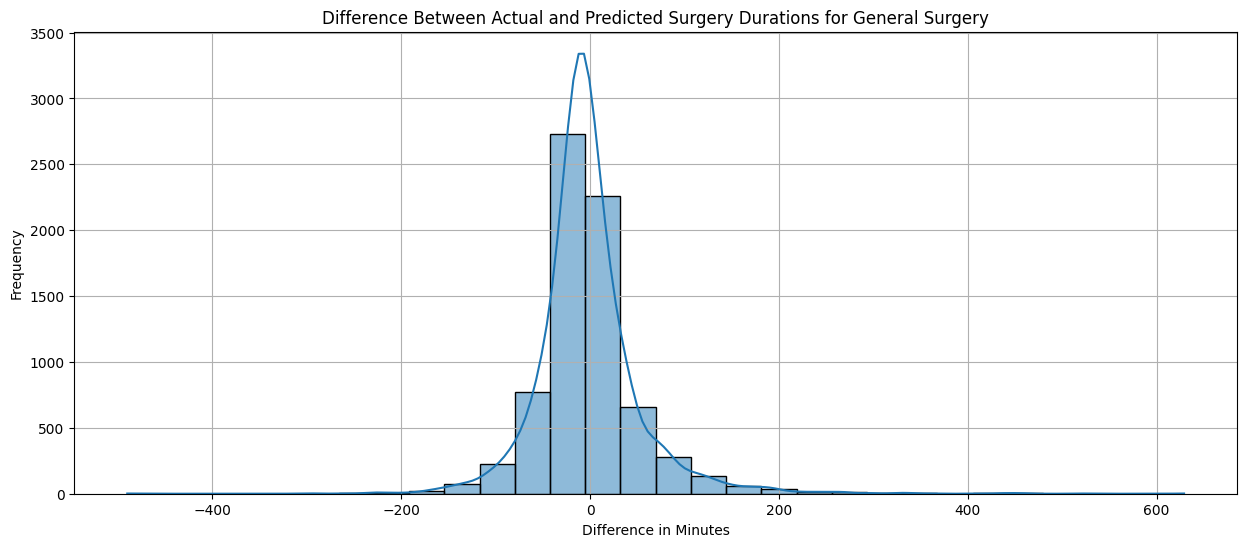

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the differences between actual and predicted durations
plt.figure(figsize=(15, 6))
sns.histplot(general_surgery_analysis_test['Difference'], kde=True, bins=30)
plt.title('Difference Between Actual and Predicted Surgery Durations for General Surgery')
plt.xlabel('Difference in Minutes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [23]:
# Calculating the absolute difference for the entire dataset
# First, we need to predict for the entire dataset using the trained models for each department
all_predictions = []

# Loop through each department, predict, and store the results
for dept in departments:
    dept_col_name = 'surgical_department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery_duration', axis=1)
        model = default_models[dept]
        dept_predictions = model.predict(X_dept)
        all_predictions.extend(dept_predictions)

# Add the predictions to the original dataframe
df_encoded['Predicted Duration'] = all_predictions

# Calculate the absolute difference for the entire dataset
df_encoded['Absolute Difference'] = abs(df_encoded['surgery_duration'] - df_encoded['Predicted Duration'])

# Sorting by highest errors
sorted_by_error = df_encoded.sort_values(by='Absolute Difference', ascending=False)

# Extracting top error data points for analysis (e.g., top 1%)
top_error_percentile = 99
top_error_threshold = np.percentile(sorted_by_error['Absolute Difference'], top_error_percentile)
top_error_data = sorted_by_error[sorted_by_error['Absolute Difference'] >= top_error_threshold]

# Analyzing common characteristics in top error data points
top_error_analysis = top_error_data.describe(include='all')

top_error_analysis



,age,BMI,admission_department,ward,surgeon_id,op_code,condition_source_value,surgery_room,surgery_duration,surgical_department_Cardiovascular Thoracic Surgery,...,division_Day,division_Outpatient,previous_surgery_N,previous_surgery_Y,emergency_status_N,emergency_status_Y,gender_source_value_F,gender_source_value_M,Predicted Duration,Absolute Difference
count,1613.00000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613,...,1613,1613,1613,1613,1613,1613,1613,1613,1613.000000,1613.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,2,2,2,2,2,2,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,False,False,True,False,True,False,False,True,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1392,...,1401,1586,1362,1362,1557,1557,917,917,NaN,NaN
mean,46.17297,22.985087,19.398636,42.587725,50.142591,1622.336640,2198.512709,20.190329,468.933664,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.801909,595.939913
std,25.57969,12.628963,13.077614,23.894553,41.687833,860.060281,1658.933822,10.810302,317.606970,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.730397,112.861205
min,1.00000,2.456497,1.000000,-1.000000,0.000000,1.000000,52.000000,0.000000,10.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.890000,487.780000
25%,20.00000,18.968021,8.000000,22.000000,21.000000,874.000000,501.000000,12.000000,77.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.940000,516.890000
50%,54.00000,22.475360,17.000000,41.000000,36.000000,1612.000000,2120.000000,21.000000,590.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.320000,558.810000
75%,67.00000,25.435620,28.000000,67.000000,76.000000,2328.000000,3725.000000,26.000000,690.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580.020000,640.750000


In [35]:
# Calculating the absolute error and error percentage for the top error data
top_error_data['Absolute Error'] = abs(top_error_data['surgery_duration'] - top_error_data['Predicted Duration'])
top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery_duration']) * 100

# Summary of the absolute error and error percentage
error_summary = top_error_data[['Absolute Error', 'Error Percentage']].describe()
error_summary

C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\3718862816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Absolute Error'] = abs(top_error_data['surgery_duration'] - top_error_data['Predicted Duration'])
C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\3718862816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery_duration']) * 100


,Absolute Error,Error Percentage
count,1613.000000,1613.000000
mean,595.939913,446.702256
std,112.861205,630.231051
min,487.780000,60.853221
25%,516.890000,87.615873
50%,558.810000,93.069686
75%,640.750000,725.500000
max,1580.230000,8563.600000


C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\1673933133.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


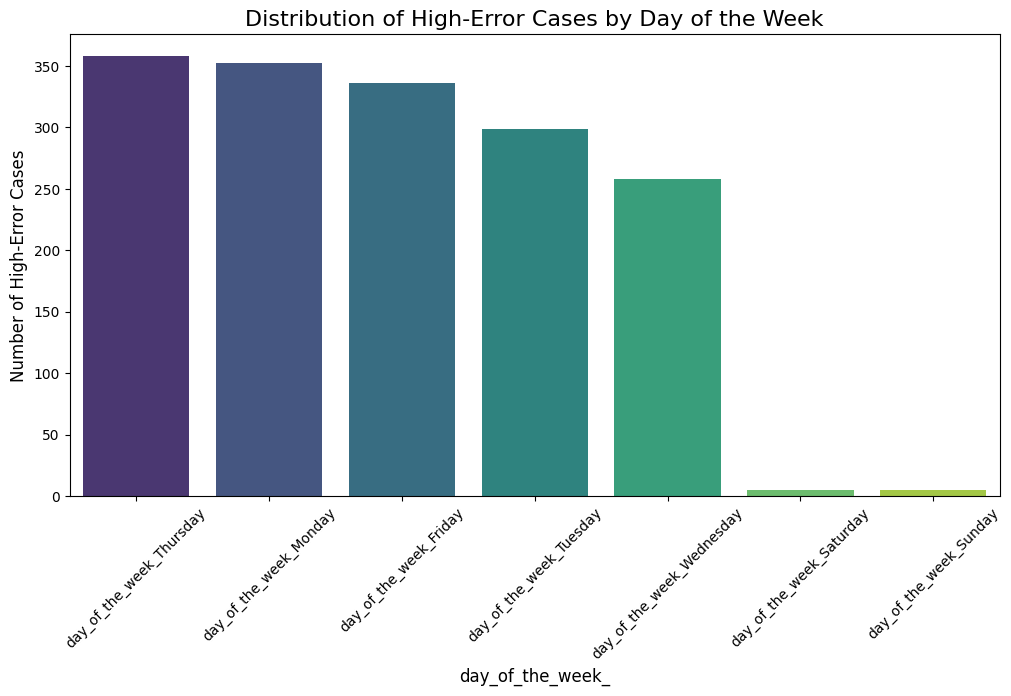

C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\1673933133.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


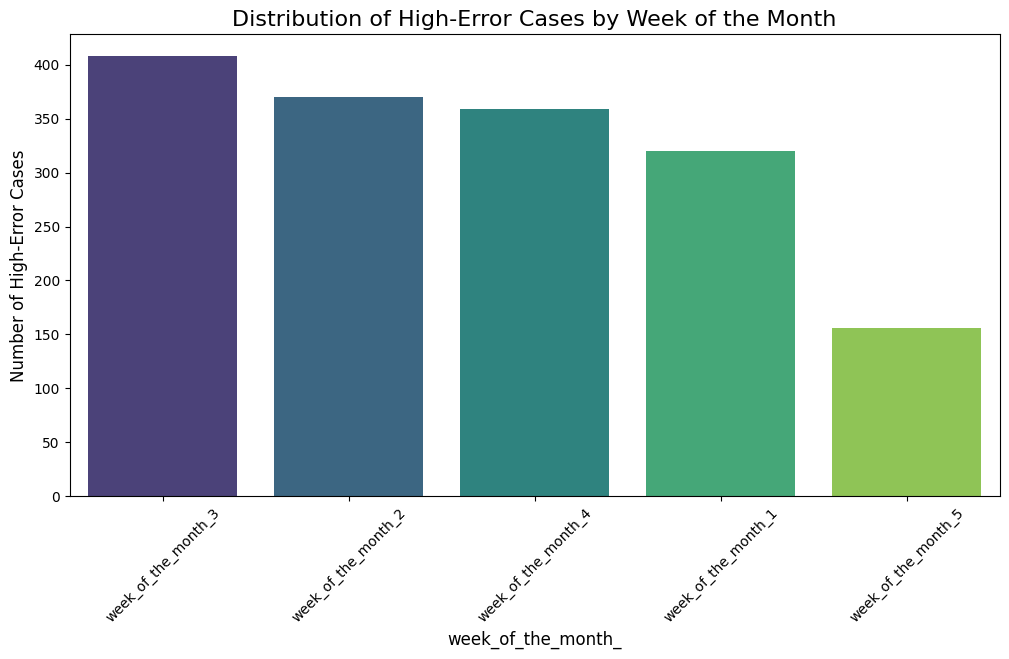

C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\1673933133.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


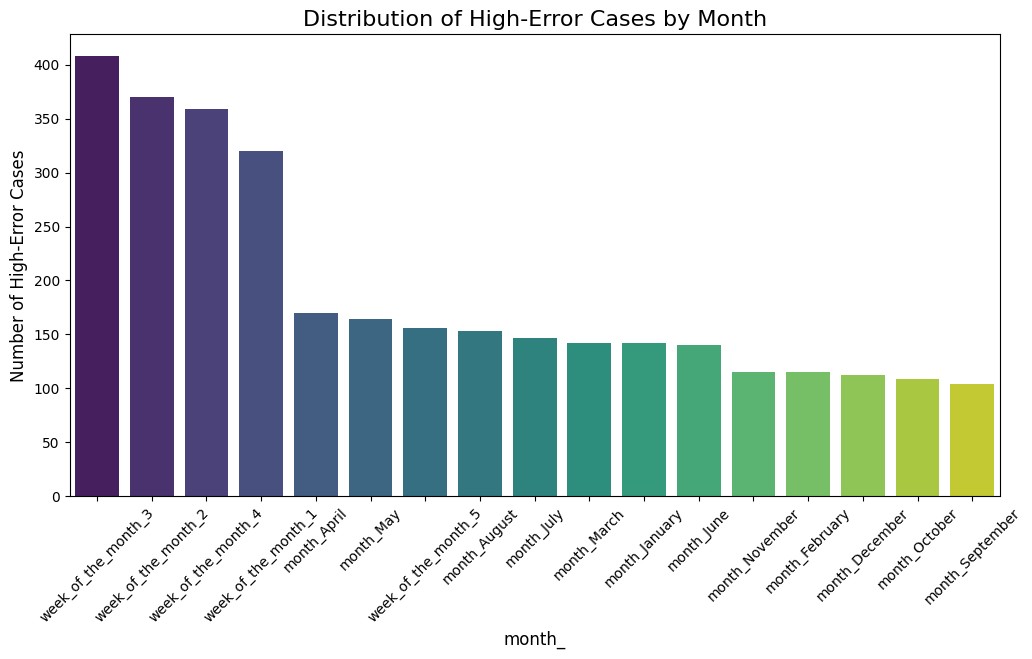

C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\1673933133.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")


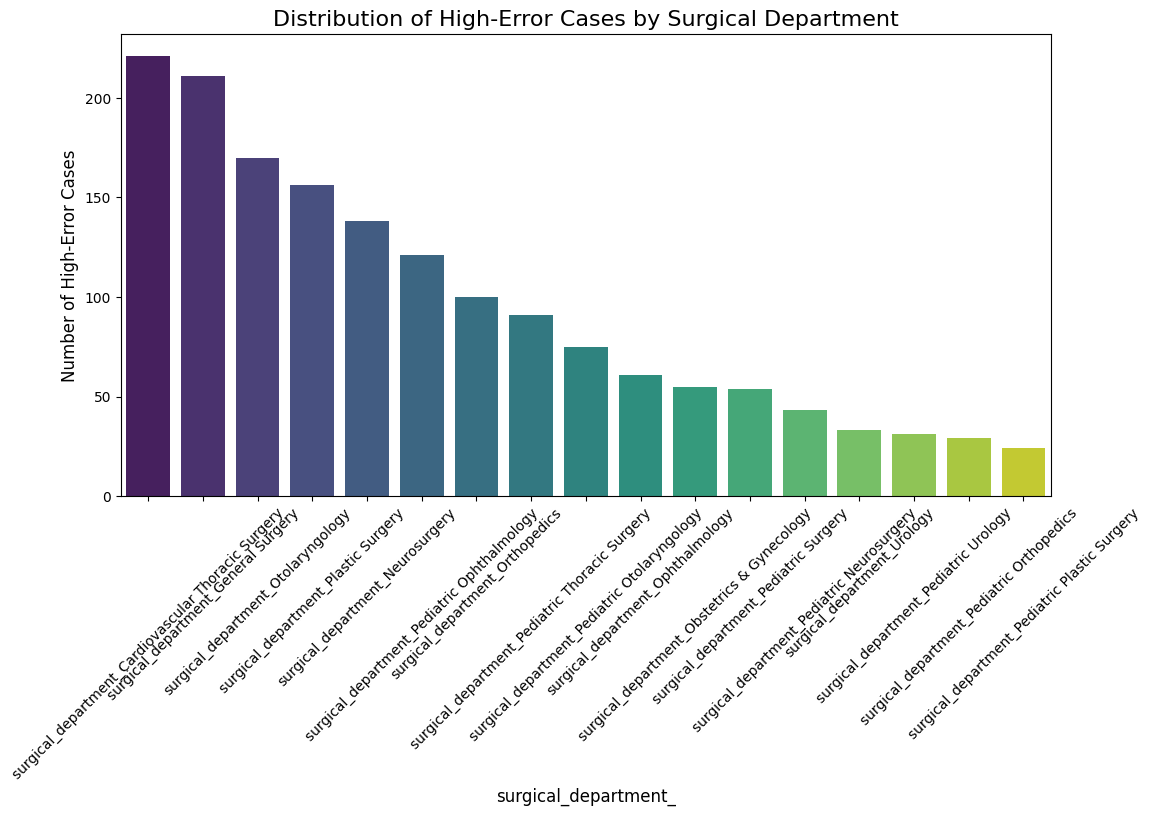

(day_of_the_week_Thursday     358
 day_of_the_week_Monday       352
 day_of_the_week_Friday       336
 day_of_the_week_Tuesday      299
 day_of_the_week_Wednesday    258
 day_of_the_week_Saturday       5
 day_of_the_week_Sunday         5
 dtype: int64,
 week_of_the_month_3    408
 week_of_the_month_2    370
 week_of_the_month_4    359
 week_of_the_month_1    320
 week_of_the_month_5    156
 dtype: int64,
 week_of_the_month_3    408
 week_of_the_month_2    370
 week_of_the_month_4    359
 week_of_the_month_1    320
 month_April            170
 month_May              164
 week_of_the_month_5    156
 month_August           153
 month_July             147
 month_March            142
 month_January          142
 month_June             140
 month_November         115
 month_February         115
 month_December         112
 month_October          109
 month_September        104
 dtype: int64,
 surgical_department_Cardiovascular Thoracic Surgery    221
 surgical_department_General Surgery     

In [39]:
# Function to create a beautiful bar plot for a given column
def plot_beautiful_distribution(df, column_prefix, title):
    # Extracting columns related to the prefix
    relevant_columns = [col for col in df.columns if column_prefix in col]

    # Summing boolean flags to calculate distribution and sorting
    distribution = df[relevant_columns].sum().sort_values(ascending=False)

    # Creating a bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=distribution.index, y=distribution.values, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.ylabel('Number of High-Error Cases', fontsize=12)
    plt.xlabel(column_prefix, fontsize=12)
    plt.show()
    return distribution

# Plotting distributions for day_of_the_week, week_of_the_month, month, and surgical_department
day_of_week_distribution_beautiful = plot_beautiful_distribution(top_error_data, 'day_of_the_week_', 'Distribution of High-Error Cases by Day of the Week')
week_of_month_distribution_beautiful = plot_beautiful_distribution(top_error_data, 'week_of_the_month_', 'Distribution of High-Error Cases by Week of the Month')
month_distribution_beautiful = plot_beautiful_distribution(top_error_data, 'month_', 'Distribution of High-Error Cases by Month')
surgical_department_distribution_beautiful = plot_beautiful_distribution(top_error_data, 'surgical_department_', 'Distribution of High-Error Cases by Surgical Department')

(day_of_week_distribution_beautiful, week_of_month_distribution_beautiful, month_distribution_beautiful, surgical_department_distribution_beautiful)



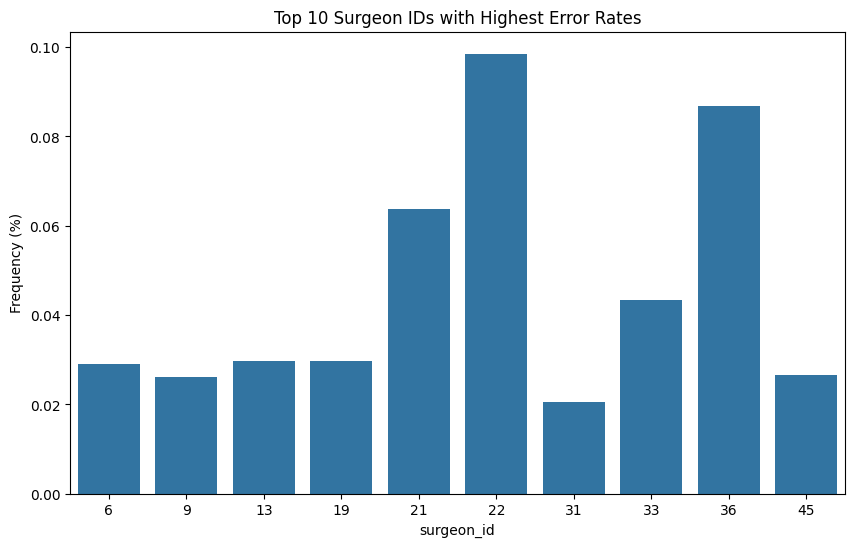

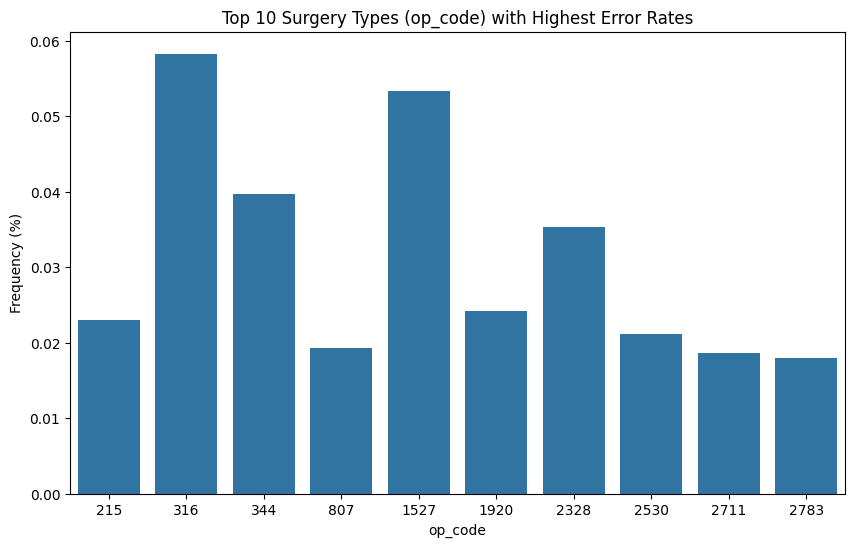

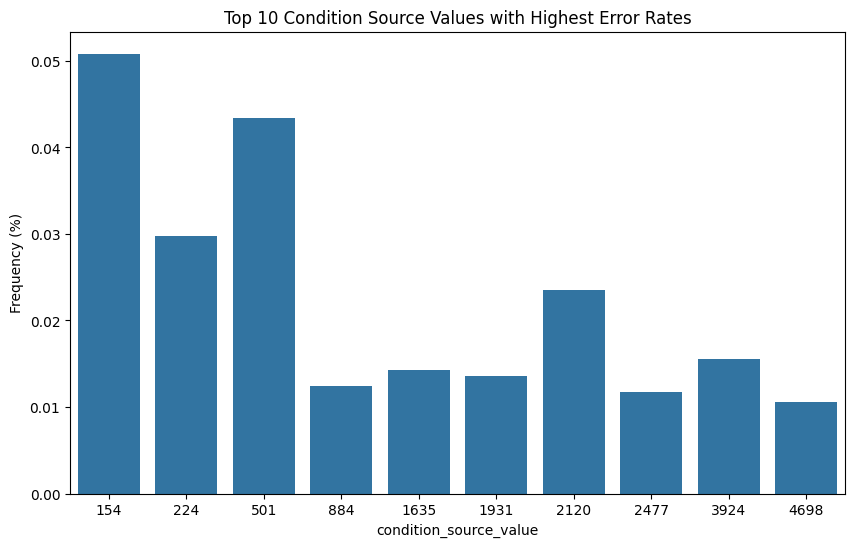

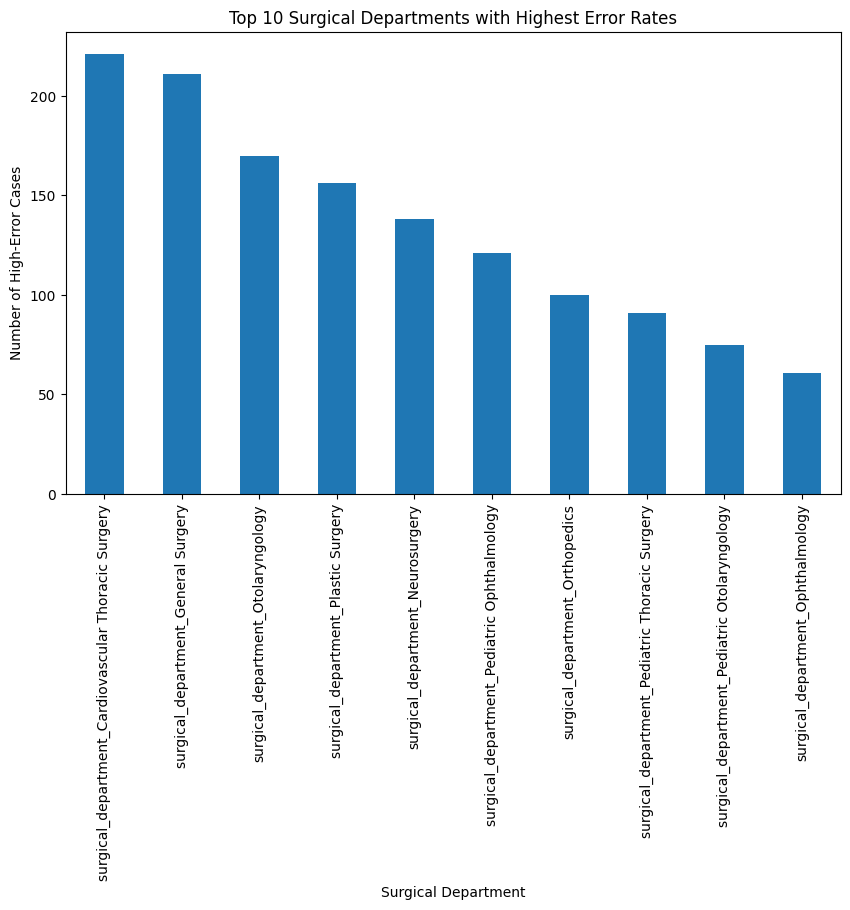

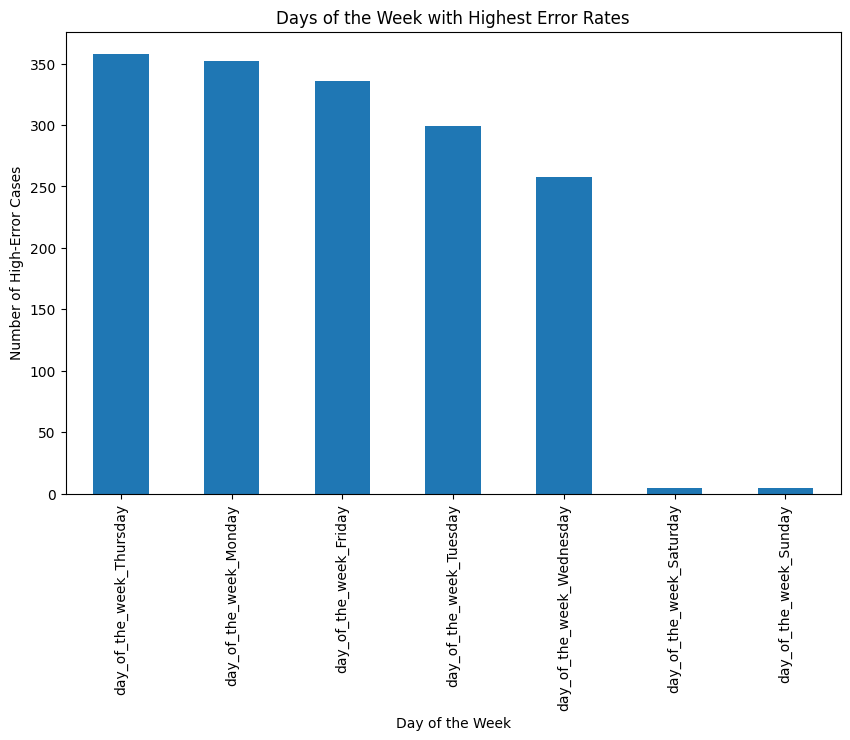

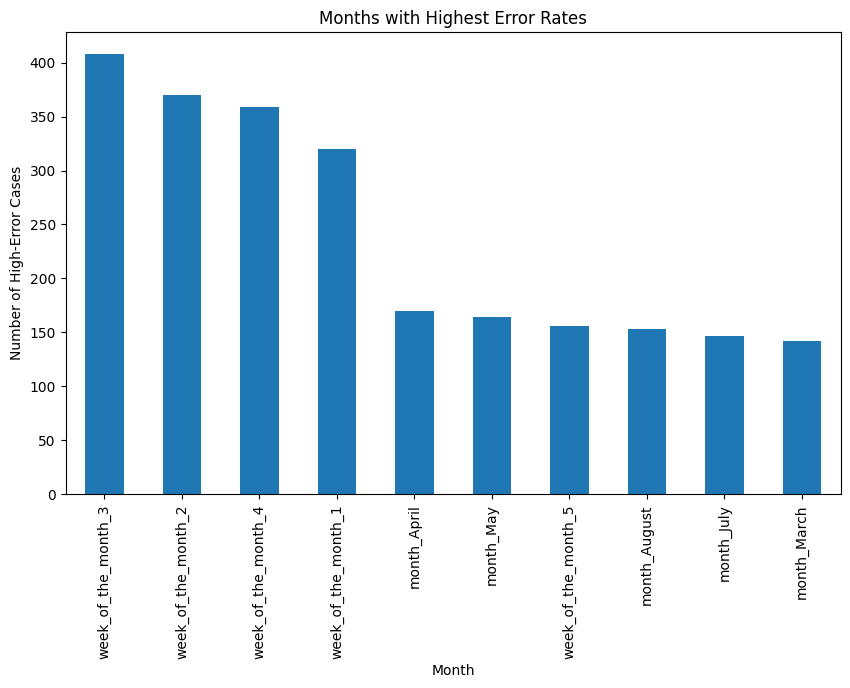

(surgeon_id
 22    0.098574
 36    0.086795
 21    0.063856
 33    0.043397
 19    0.029758
 13    0.029758
 6     0.029138
 45    0.026658
 9     0.026038
 31    0.020459
 Name: proportion, dtype: float64,
 op_code
 316     0.058277
 1527    0.053317
 344     0.039678
 2328    0.035338
 1920    0.024179
 215     0.022939
 2530    0.021079
 807     0.019219
 2711    0.018599
 2783    0.017979
 Name: proportion, dtype: float64,
 condition_source_value
 154     0.050837
 501     0.043397
 224     0.029758
 2120    0.023559
 3924    0.015499
 1635    0.014259
 1931    0.013639
 884     0.012399
 2477    0.011779
 4698    0.010539
 Name: proportion, dtype: float64,
 surgical_department_Cardiovascular Thoracic Surgery    221
 surgical_department_General Surgery                    211
 surgical_department_Otolaryngology                     170
 surgical_department_Plastic Surgery                    156
 surgical_department_Neurosurgery                       138
 surgical_department_Pediatric

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate and plot the distribution of a given column
def plot_distribution(df, column_name, title):
    distribution = df[column_name].value_counts(normalize=True).head(10)  # Taking top 10 for clarity
    plt.figure(figsize=(10, 6))
    sns.barplot(x=distribution.index, y=distribution.values)
    plt.title(title)
    plt.ylabel('Frequency (%)')
    plt.xlabel(column_name)
    plt.show()
    return distribution

# Plotting distributions for the requested columns
surgeon_id_distribution = plot_distribution(top_error_data, 'surgeon_id', 'Top 10 Surgeon IDs with Highest Error Rates')
op_code_distribution = plot_distribution(top_error_data, 'op_code', 'Top 10 Surgery Types (op_code) with Highest Error Rates')
condition_source_value_distribution = plot_distribution(top_error_data, 'condition_source_value', 'Top 10 Condition Source Values with Highest Error Rates')

# For surgical departments, day of the week, and month, extracting the relevant columns
surgical_department_columns = [col for col in top_error_data.columns if 'surgical_department_' in col]
day_of_week_columns = [col for col in top_error_data.columns if 'day_of_the_week_' in col]
month_columns = [col for col in top_error_data.columns if 'month_' in col]

# Summing boolean flags to calculate distribution
surgical_department_distribution = top_error_data[surgical_department_columns].sum().sort_values(ascending=False).head(10)
day_of_week_distribution = top_error_data[day_of_week_columns].sum().sort_values(ascending=False).head(10)
month_distribution = top_error_data[month_columns].sum().sort_values(ascending=False).head(10)

# Plotting distributions for surgical departments, day of the week, and month
plt.figure(figsize=(10, 6))
surgical_department_distribution.plot(kind='bar')
plt.title('Top 10 Surgical Departments with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Surgical Department')
plt.show()

plt.figure(figsize=(10, 6))
day_of_week_distribution.plot(kind='bar')
plt.title('Days of the Week with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Day of the Week')
plt.show()

plt.figure(figsize=(10, 6))
month_distribution.plot(kind='bar')
plt.title('Months with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Month')
plt.show()

# Returning the distributions for detailed view
(surgeon_id_distribution, op_code_distribution, condition_source_value_distribution, surgical_department_distribution, day_of_week_distribution, month_distribution)



In [32]:
# Re-merging the original dataset with the top error data points for broader analysis
top_error_data_broad_corrected = df.merge(top_error_data, left_index=True, right_index=True, how='inner')

# Analyzing departments with most high-error cases
dept_error_distribution_corrected = top_error_data_broad_corrected['surgical_department'].value_counts()

# Analyzing surgery types with most high-error cases

# Analyzing patient demographics (age and gender) in high-error cases
gender_distribution_corrected = top_error_data_broad_corrected['gender_source_value'].value_counts()

# Analyzing time-related factors (day of the week, month, etc.)
day_of_week_distribution_corrected = top_error_data_broad_corrected['day_of_the_week'].value_counts()
month_distribution_corrected = top_error_data_broad_corrected['month'].value_counts()

# Collecting analysis results
analysis_results_corrected = {
    "Department Error Distribution": dept_error_distribution_corrected,
    "Gender Distribution of High-Error Cases": gender_distribution_corrected,
    "Day of the Week Distribution in High-Error Cases": day_of_week_distribution_corrected,
    "Month Distribution in High-Error Cases": month_distribution_corrected
}

analysis_results_corrected



{'Department Error Distribution': surgical_department
 Cardiovascular Thoracic Surgery    221
 General Surgery                    211
 Otolaryngology                     170
 Plastic Surgery                    156
 Neurosurgery                       138
 Pediatric Ophthalmology            121
 Orthopedics                        100
 Pediatric Thoracic Surgery          91
 Pediatric Otolaryngology            75
 Ophthalmology                       61
 Obstetrics & Gynecology             55
 Pediatric Surgery                   54
 Pediatric Neurosurgery              43
 Urology                             33
 Pediatric Urology                   31
 Pediatric Orthopedics               29
 Pediatric Plastic Surgery           24
 Name: count, dtype: int64,
 'Gender Distribution of High-Error Cases': gender_source_value
 M    917
 F    696
 Name: count, dtype: int64,
 'Day of the Week Distribution in High-Error Cases': day_of_the_week
 Thursday     358
 Monday       352
 Friday       336
 Tu

In [33]:
top_error_data_broad_corrected

,age_x,gender_source_value,BMI_x,admission_department_x,division,ward_x,asa_class,surgeon_id_x,surgical_department,op_code_x,...,division_Day,division_Outpatient,previous_surgery_N,previous_surgery_Y,emergency_status_N,emergency_status_Y,gender_source_value_F,gender_source_value_M,Predicted Duration,Absolute Difference
120,96,M,25.640568,8,Admission,59,2,75,General Surgery,1105,...,False,False,True,False,False,True,False,True,68.51,669.49
355,67,M,26.564813,1,Admission,68,3,13,Cardiovascular Thoracic Surgery,344,...,False,False,True,False,True,False,False,True,150.96,524.04
411,69,M,29.912202,1,Admission,68,3,117,Cardiovascular Thoracic Surgery,2300,...,False,False,True,False,True,False,False,True,72.54,490.46
723,68,F,25.912106,15,Day,41,2,111,Ophthalmology,1920,...,True,False,True,False,True,False,True,False,520.74,494.74
1298,43,M,24.048050,30,Admission,67,3,33,Pediatric Thoracic Surgery,344,...,False,False,True,False,True,False,False,True,213.46,611.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161062,1,F,17.107895,23,Admission,29,1,31,Pediatric Ophthalmology,2360,...,False,False,True,False,True,False,True,False,654.87,596.87
161088,5,F,16.660872,29,Day,65,1,145,Pediatric Surgery,1520,...,True,False,True,False,True,False,True,False,866.36,856.36
161103,1,M,11.609977,29,Admission,67,2,148,Pediatric Surgery,2504,...,False,False,True,False,True,False,False,True,743.77,504.77
161118,13,F,24.605254,25,Day,65,2,20,Pediatric Otolaryngology,874,...,True,False,True,False,True,False,True,False,561.58,518.58


In [28]:
# Extracting the top 1% highest-error data points for broader analysis
top_error_data_broad = df.merge(top_error_data, left_index=True, right_index=True)

# Correcting the syntax error and re-running the analysis

# Analyzing departments with most high-error cases
dept_error_distribution = top_error_data_broad['surgical_department'].value_counts()

# Analyzing surgery types with most high-error cases
surgery_type_error_distribution = top_error_data_broad['op_code'].value_counts()

# Analyzing patient demographics (age and gender) in high-error cases
age_distribution = top_error_data_broad['age'].describe()
gender_distribution = top_error_data_broad['gender_source_value'].value_counts()

# Analyzing time-related factors (day of the week, month, etc.)
day_of_week_distribution = top_error_data_broad['day_of_the_week'].value_counts()
month_distribution = top_error_data_broad['month'].value_counts()

# Collecting analysis results
analysis_results = {
    "Department Error Distribution": dept_error_distribution,
    "Surgery Type Error Distribution": surgery_type_error_distribution,
    "Age Distribution of High-Error Cases": age_distribution,
    "Gender Distribution of High-Error Cases": gender_distribution,
    "Day of the Week Distribution in High-Error Cases": day_of_week_distribution,
    "Month Distribution in High-Error Cases": month_distribution
}

analysis_results


KeyError: 'op_code'

C:\Users\SNUH\AppData\Local\Temp\ipykernel_3220\1165098147.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')


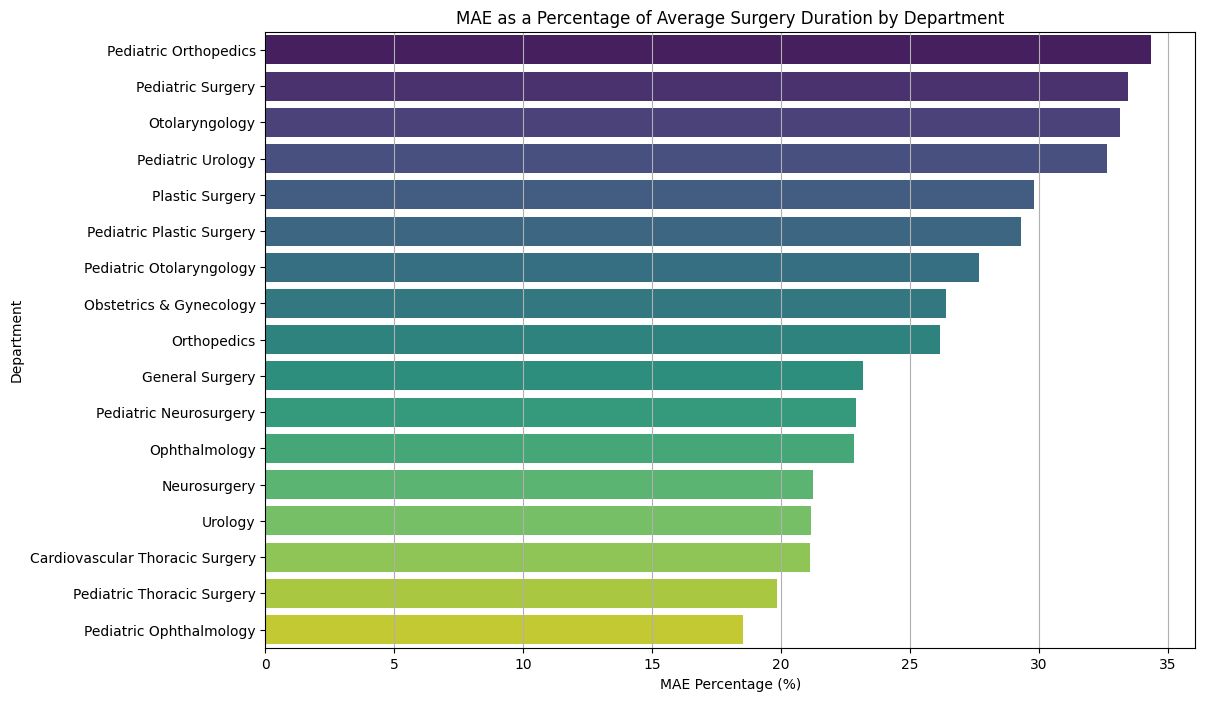

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the MAE as a percentage of the average surgery duration
dept_data_for_visualization['MAE Percentage'] = (dept_data_for_visualization['MAE'] / dept_data_for_visualization['Average Surgery Duration']) * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')
    
plt.title('MAE as a Percentage of Average Surgery Duration by Department')
plt.xlabel('MAE Percentage (%)')
plt.ylabel('Department')
plt.grid(axis='x')
plt.show()



In [8]:
# Separating the departments into pediatric and adult categories
pediatric_data = dept_data_for_visualization[dept_data_for_visualization['Department'].str.startswith('Pediatric')]
adult_data = dept_data_for_visualization[~dept_data_for_visualization['Department'].str.startswith('Pediatric')]

In [9]:
# Sorting the adult and pediatric data based on Average Surgery Duration
adult_data_sorted = adult_data.sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_sorted = pediatric_data.sort_values(by='Average Surgery Duration', ascending=False)

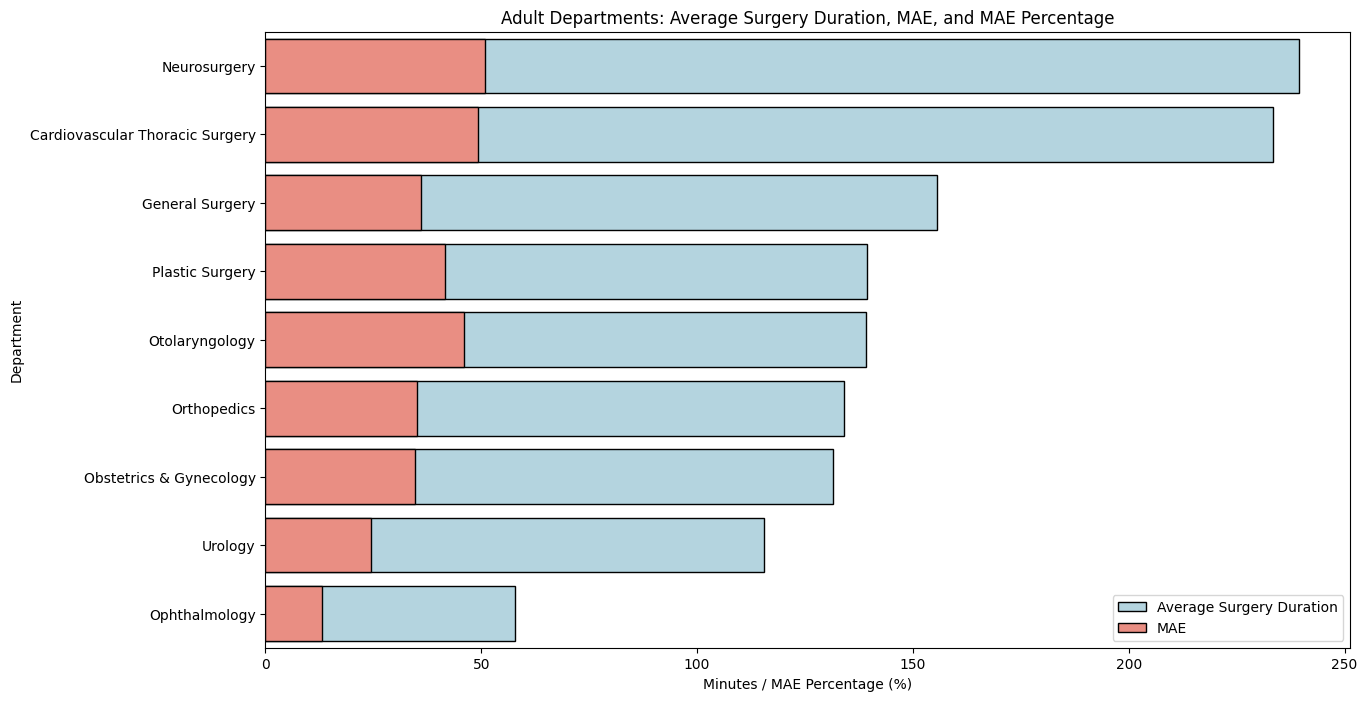

In [10]:
# Combined plot for both Adult and Pediatric Departments, sorted by Average Surgery Duration
plt.figure(figsize=(14, 8))

# Plot for Adult Departments
sns.barplot(x='Average Surgery Duration', y='Department', data=adult_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=adult_data_sorted, color='salmon', edgecolor='black', label='MAE')
plt.title('Adult Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

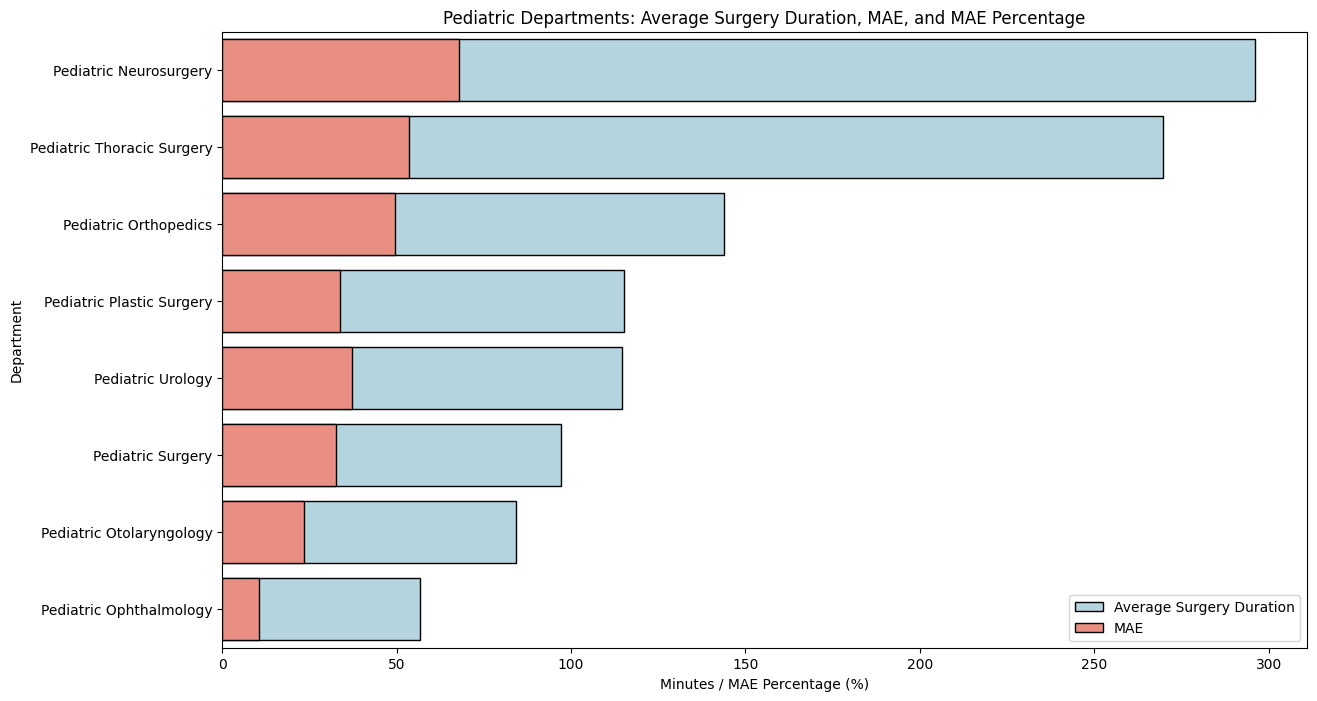

In [11]:
# Plot for Pediatric Departments
plt.figure(figsize=(14, 8))
sns.barplot(x='Average Surgery Duration', y='Department', data=pediatric_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=pediatric_data_sorted, color='salmon', edgecolor='black', label='MAE')
plt.title('Pediatric Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

In [12]:
# Displaying adult_data as a table
adult_data_table = adult_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
adult_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
7,Neurosurgery,239.383053,50.865132,21.248427
8,Cardiovascular Thoracic Surgery,233.352425,49.312531,21.132213
0,General Surgery,155.665771,36.062333,23.166515
6,Plastic Surgery,139.252837,41.503558,29.804461
1,Otolaryngology,139.036018,46.074115,33.138258
2,Orthopedics,133.923572,35.027960,26.155187
4,Obstetrics & Gynecology,131.534839,34.729579,26.403331
5,Urology,115.427910,24.448768,21.180985
3,Ophthalmology,57.755921,13.188377,22.834676


In [13]:
# Displaying adult_data as a table
pediatric_data_table = pediatric_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
16,Pediatric Neurosurgery,296.249571,67.894530,22.918018
11,Pediatric Thoracic Surgery,269.852878,53.523484,19.834320
10,Pediatric Orthopedics,143.927017,49.453355,34.360022
15,Pediatric Plastic Surgery,115.201977,33.751459,29.297638
12,Pediatric Urology,114.517983,37.368403,32.631035
13,Pediatric Surgery,97.210395,32.537068,33.470770
9,Pediatric Otolaryngology,84.302394,23.332767,27.677466
14,Pediatric Ophthalmology,56.627339,10.492786,18.529542


In [14]:
# Training a model on the entire dataset
full_model = RandomForestRegressor(random_state=42)
full_model.fit(X_train_all, y_train_all)

# Predicting on the test set
full_model_predictions = full_model.predict(X_test_all)

# Evaluating the full model's performance
full_model_mae = mean_absolute_error(y_test_all, full_model_predictions)
full_model_rmse = np.sqrt(mean_squared_error(y_test_all, full_model_predictions))
full_model_r2 = r2_score(y_test_all, full_model_predictions)

full_model_mae, full_model_rmse, full_model_r2


(34.04604403920109, 57.451605225030455, 0.7228655762174734)

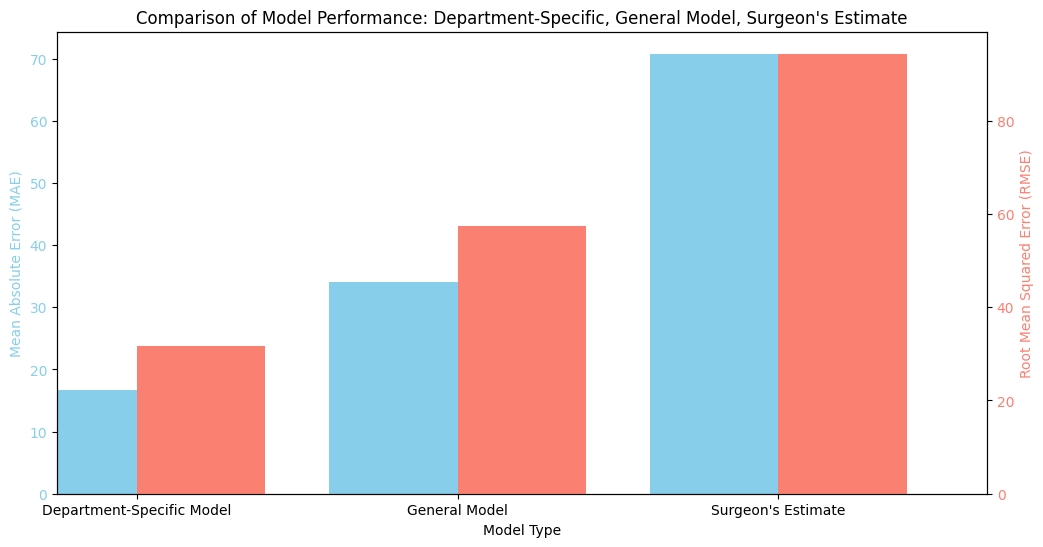

,MAE,RMSE
Model Type,,
Department-Specific Model,16.678703,31.662394
General Model,34.046044,57.451605
Surgeon's Estimate,70.819252,94.346930


In [15]:
import matplotlib.pyplot as plt

# Preparing data for comparison plot and table
comparison_data = {
    "Model Type": ["Department-Specific Model", "General Model", "Surgeon's Estimate"],
    "MAE": [mae, full_model_mae, surgeon_mae],
    "RMSE": [rmse, full_model_rmse, surgeon_rmse]
}

# Creating a DataFrame for easy plotting
comparison_df = pd.DataFrame(comparison_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for MAE
comparison_df.plot(kind='bar', x='Model Type', y='MAE', ax=ax1, color='skyblue', position=1, width=0.4, legend=False)
ax1.set_ylabel('Mean Absolute Error (MAE)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Creating a second y-axis for RMSE
ax2 = ax1.twinx()
comparison_df.plot(kind='bar', x='Model Type', y='RMSE', ax=ax2, color='salmon', position=0, width=0.4, legend=False)
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Title and labels
plt.title('Comparison of Model Performance: Department-Specific, General Model, Surgeon\'s Estimate')
ax1.set_xlabel('Model Type')

plt.show()
# Creating a table for comparison
comparison_table = comparison_df.set_index('Model Type')
comparison_table
